In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
from model_utils import *
loc_df, X_loc_train, y_loc_train, X_loc_valid, y_loc_valid, X_loc_test, y_loc_test = load_loc_data('../')
vec_df, X_vec_train, y_vec_train, X_vec_valid, y_vec_valid, X_vec_test, y_vec_test = load_vec_data('../')

In [3]:
loc_clf = RandomForestClassifier(n_estimators=60)
loc_clf.fit(X_loc_train, y_loc_train);

In [11]:
vec_clf = RandomForestClassifier(n_estimators=60)
vec_clf.fit(X_vec_train, y_vec_train);

In [15]:
val_preds1 = loc_clf.predict_proba(X_loc_train)[:, 1]
val_preds2 = vec_clf.predict_proba(X_vec_train)[:, 1]

stacked_features = np.column_stack((val_preds1, val_preds2))


meta_model = LogisticRegression()
meta_model.fit(stacked_features, y_loc_train);

In [16]:
test_preds1 = loc_clf.predict_proba(X_loc_test)[:, 1]
test_preds2 = vec_clf.predict_proba(X_vec_test)[:, 1]
test_x  = np.column_stack((test_preds1, test_preds2))

test_pred = meta_model.predict(test_x)

accuracy = accuracy_score(y_loc_test, test_pred)
cm = confusion_matrix(y_loc_test, test_pred)
precision = precision_score(y_loc_test, test_pred)
recall = recall_score(y_loc_test, test_pred)

TN = cm[0, 0]
FP = cm[0, 1]
specificity = TN / (TN + FP)

print(f"CM: \n{cm}")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Accuracy: {accuracy:.2f}')

CM: 
[[ 28  36]
 [  7 214]]
Precision: 0.86
Recall: 0.97
Specificity: 0.44
Accuracy: 0.85


In [19]:
loc_model = xgb.XGBClassifier(objective='multi:softprob', num_class=2, eval_metric="mlogloss")
loc_model.fit(X_loc_train, y_loc_train);

In [20]:
vec_model = xgb.XGBClassifier(objective='multi:softprob', num_class=2, eval_metric="mlogloss")
vec_model.fit(X_vec_train, y_vec_train);

In [23]:
val_preds1 = loc_model.predict_proba(X_loc_train)[:, 1]
val_preds2 = vec_model.predict_proba(X_vec_train)[:, 1]

stacked_features = np.column_stack((val_preds1, val_preds2))

meta_model = xgb.XGBClassifier(objective='multi:softprob', num_class=2, eval_metric="mlogloss")
meta_model.fit(stacked_features, y_loc_train);

In [25]:
test_preds1 = loc_model.predict_proba(X_loc_test)[:, 1]
test_preds2 = vec_model.predict_proba(X_vec_test)[:, 1]
test_x  = np.column_stack((test_preds1, test_preds2))

test_pred = meta_model.predict(test_x)


In [40]:
accuracy = accuracy_score(y_loc_test, test_pred[:, 1])
cm = confusion_matrix(y_loc_test, test_pred[:, 1])
precision = precision_score(y_loc_test, test_pred[:, 1])
recall = recall_score(y_loc_test, test_pred[:, 1])

TN = cm[0, 0]
FP = cm[0, 1]
specificity = TN / (TN + FP)

print(f"CM: \n{cm}")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Accuracy: {accuracy:.2f}')

CM: 
[[ 36  28]
 [ 14 207]]
Precision: 0.88
Recall: 0.94
Specificity: 0.56
Accuracy: 0.85


In [3]:
x_train = pd.concat([X_loc_train, X_vec_train], axis=1)
x_valid = pd.concat([X_loc_valid, X_vec_valid], axis=1)
x_test = pd.concat([X_loc_test, X_vec_test], axis=1)

In [7]:
y_loc_test.value_counts().get(0, 0)

64

In [5]:
model1 = xgb.XGBClassifier(objective='multi:softprob', num_class=2, eval_metric="mlogloss")
model1.fit(x_train, y_loc_train);

In [6]:
preds_valid = model1.predict(x_valid)
preds_test = model1.predict(x_test)

apply_metric(y_loc_valid, preds_valid[:, 1], enable_print=True)
apply_metric(y_loc_test, preds_test[:, 1], enable_print=True);

CM: 
[[ 39  25]
 [ 18 202]]
Precision: 0.89
Recall: 0.92
Specificity: 0.61
Accuracy: 0.85
CM: 
[[ 33  31]
 [  9 212]]
Precision: 0.87
Recall: 0.96
Specificity: 0.52
Accuracy: 0.86


In [8]:
model2 = LogisticRegression(max_iter=10000)
model2.fit(x_train, y_loc_train);

In [9]:
preds_valid = model2.predict(x_valid)
preds_test = model2.predict(x_test)

apply_metric(y_loc_valid, preds_valid, enable_print=True)
apply_metric(y_loc_test, preds_test, enable_print=True);

CM: 
[[ 44  20]
 [ 31 189]]
Precision: 0.90
Recall: 0.86
Specificity: 0.69
Accuracy: 0.82
CM: 
[[ 42  22]
 [ 22 199]]
Precision: 0.90
Recall: 0.90
Specificity: 0.66
Accuracy: 0.85


In [8]:
precisions_1, recalls_1, specificities_1 = [], [], []
precisions_2, recalls_2, specificities_2 = [], [], []
rang = np.arange(0.1, 0.91, 0.01)

for th in rang:
    test_probs = loc_clf.predict_proba(X_loc_test)[:, 1]
    test_pred = (test_probs >= th).astype(int)
    prec1, recal1, spec1, _ = apply_metric(test_pred, y_loc_test)
    valid_probs = loc_clf.predict_proba(X_loc_valid)[:, 1]
    valid_pred = (valid_probs >= th).astype(int)
    prec2, recal2, spec2, _ = apply_metric(valid_pred, y_loc_valid)
    precisions_1.append(prec1)
    recalls_1.append(recal1)
    specificities_1.append(spec1)
    precisions_2.append(prec2)
    recalls_2.append(recal2)
    specificities_2.append(spec2)

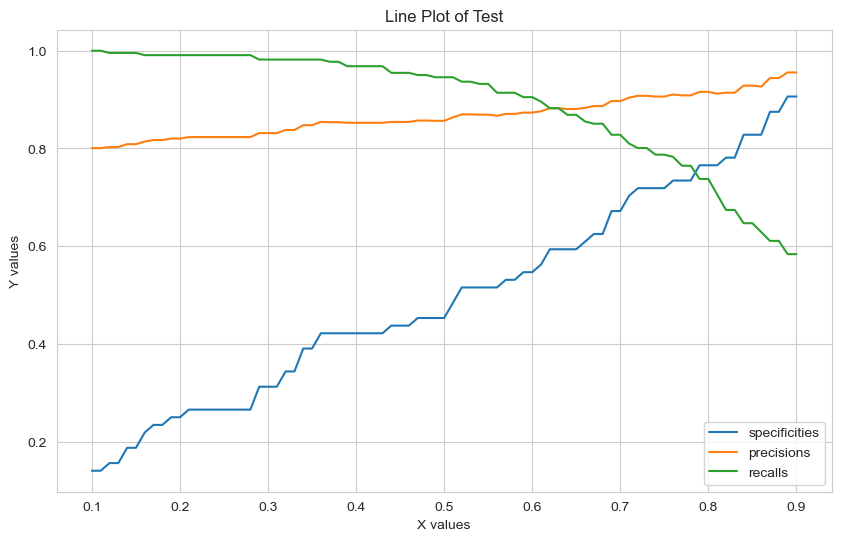

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(rang, specificities_1, label='specificities')
plt.plot(rang, precisions_1, label='precisions')
plt.plot(rang, recalls_1, label='recalls')

plt.title('Line Plot of Test')
plt.xlabel('X values')
plt.ylabel('Y values')

plt.legend()

plt.grid(True)
plt.show()

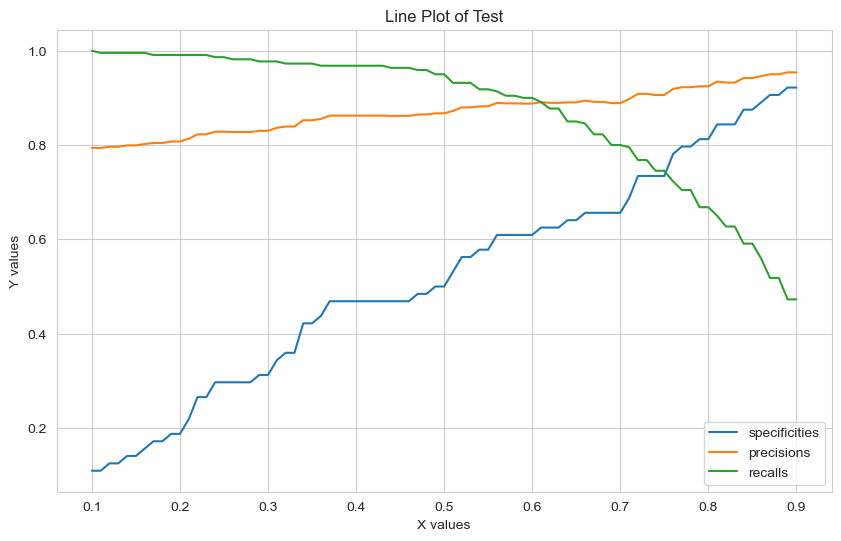

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(rang, specificities_2, label='specificities')
plt.plot(rang, precisions_2, label='precisions')
plt.plot(rang, recalls_2, label='recalls')

plt.title('Line Plot of Test')
plt.xlabel('X values')
plt.ylabel('Y values')

plt.legend()

plt.grid(True)
plt.show()

In [ ]:
scores = []
precisions, recalls,specificities = [], [], []

for n in np.arange(10, 1000, 10):
    clf = RandomForestClassifier(n_estimators=n)  # max_iter may be set higher if convergence issues occur

    clf.fit(X_resampled, y_resampled)
    score = cross_val_score(clf, X, y, cv=5)
    scores.append(score.mean())

    y_pred = clf.predict(X_test)
    confusion_matrix(y_test, y_pred)

    cm1 = confusion_matrix(y_test, y_pred)
    precision1 = precision_score(y_test, y_pred)
    recall1 = recall_score(y_test, y_pred)
    TN1 = cm1[0, 0]
    FP1 = cm1[0, 1]
    specificity1 = TN1 / (TN1 + FP1)
    precisions.append(precision1)
    recalls.append(recall1)
    specificities.append(specificity1)

In [ ]:
import matplotlib.pyplot as plt

rang = np.arange(10, 1000, 10)

# Plot the data
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(rang, scores, label='RF Scores')
plt.plot(rang, precisions, label='precisions')
plt.plot(rang, recalls, label='recalls')
plt.plot(rang, specificities, label='specificities')

# Adding title and labels
plt.title('Line Plot of scores')
plt.xlabel('X values (10 to 300')
plt.ylabel('Y values')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)  # Optional: Add grid for better readability
plt.show()